## 필요한 패키지 import 

In [1]:
import keras
import warnings

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

import os
os.chdir(r'C:\Users\joyh1\Desktop\DSC\DSC_음메\cow_data\final_data')

warnings.filterwarnings(action='ignore')

Using TensorFlow backend.


## 데이터 로드

In [26]:
data = pd.read_excel('축산물.xlsx')
weather = pd.read_pickle('관측정보.pkl')
print('data shape: ', data.shape)
print('weather shape: ', weather.shape)

data shape:  (985, 6)
weather shape:  (939, 7)


## 한우가격 시계열 데이터 정상성 여부 확인

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


def check_stationarity(y, lags_plots=48, figsize=(16,8)):
    "Use Series as parameter"
    
    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title('한우가격_미래값(y값)')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(np.sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()
    
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

Results of Dickey-Fuller Test:
Test Statistic                  -3.4150
p-value                          0.0105
Lags Used                        9.0000
Number of Observations Used    975.0000
Critical Value (1%)             -3.4371
Critical Value (5%)             -2.8645
Critical Value (10%)            -2.5684
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


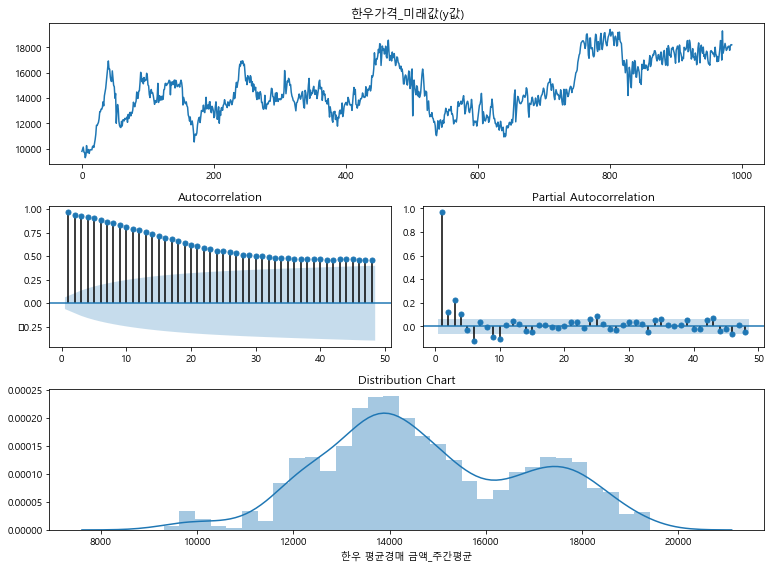

In [4]:
check_stationarity(data['한우 평균경매 금액_주간평균'])

## 사용할 최종 데이터 만들기

In [28]:
data2 = pd.merge(data,weather,on='주간날짜')

del data2['Unnamed: 0']
del data2['year']
del data2['month']
del data2['날짜']

data2 = data2.reset_index()
del data2['index']

# 한우가격 예측하려는 값(y값) 한 칸씩 땡기기
data2['y_value'] = 1
for i in range(0,(len(data2)-1)):
    data2['y_value'][i] = data2['한우 평균경매 금액_주간평균'][i+1]
    
data2['y_value'] = data2['y_value'].astype('float')
data2.head()

,주간날짜,한우 평균경매 금액_주간평균,평균기온,최저기온,최고기온,평균지면온도,최소상대습도(%),평균상대습도(%),y_value
0,2001-02-11,9798.0,-0.500000,-3.800000,3.814286,0.400000,20.857143,39.085714,9973.0
1,2001-02-18,9973.2,6.128571,1.685714,10.914286,4.057143,39.428571,60.328571,10136.0
2,2001-02-25,10136.5,5.042857,-0.257143,11.171429,4.857143,29.571429,55.385714,9740.0
3,2001-03-04,9740.8,1.214286,-2.728571,5.585714,2.885714,26.000000,44.557143,9707.0
4,2001-03-11,9707.2,5.828571,0.328571,11.642857,6.414286,29.571429,52.171429,9300.0


In [29]:
data2[data2['평균지면온도'].isnull()]

,주간날짜,한우 평균경매 금액_주간평균,평균기온,최저기온,최고기온,평균지면온도,최소상대습도(%),평균상대습도(%),y_value
681,2014-03-02,13824.80,2.514286,-1.885714,7.2,NaN,28.000000,53.142857,14069.0
746,2015-05-31,15353.20,22.485714,16.771429,27.6,NaN,22.428571,41.585714,15643.0
933,2018-12-30,17944.75,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [30]:
data2.isnull().sum()

주간날짜               0
한우 평균경매 금액_주간평균    0
평균기온               1
최저기온               1
최고기온               1
평균지면온도             3
최소상대습도(%)          1
평균상대습도(%)          1
y_value            0
dtype: int64

In [31]:
del data2['한우 평균경매 금액_주간평균']

In [32]:
# lag변수 추가
data2['lag1_price'] = data2['y_value'].shift(1)
data2['lag2_price'] = data2['y_value'].shift(2)
data2['lag3_price'] = data2['y_value'].shift(3)
data2['lag5_price'] = data2['y_value'].shift(5)
data2['lag10_price'] = data2['y_value'].shift(10)
data2['lag15_price'] = data2['y_value'].shift(15)

In [34]:
# na값 들어있는 데이터 삭제
data2 = data2.dropna()

In [55]:
# 7:3 비율로 train, test 데이터 split
train = data2.iloc[:690,:]
test = data2.iloc[690:]

## Feature Selection

In [56]:
train_x = train.drop(['주간날짜','y_value'], axis=1)
test_x = test.drop(['주간날짜','y_value'], axis=1)
train_y = train[['y_value']]
test_y = test[['y_value']]

In [57]:
feature_names = data2.drop(['주간날짜','y_value'],axis=1).columns
feature_names = [list(i) for i in feature_names]
feature_names = [''.join(i) for i in feature_names]
print(feature_names)

['평균기온', '최저기온', '최고기온', '평균지면온도', '최소상대습도(%)', '평균상대습도(%)', 'lag1_price', 'lag2_price', 'lag3_price', 'lag5_price', 'lag10_price', 'lag15_price']


In [58]:
# Sequential Feature Seletor
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn import datasets, linear_model

clf = linear_model.LinearRegression()

# Build step forward feature selection                              # cv = cross_validation
sfs1 = sfs(clf,k_features = 5,forward=True,floating=False, scoring='r2',cv=5)

# Perform SFFS
sfs1 = sfs1.fit(train_x, train_y,custom_feature_names=feature_names)
features = list(sfs1.k_feature_names_)
print(features)

['최소상대습도(%)', 'lag1_price', 'lag3_price', 'lag5_price', 'lag10_price']


## Feature Normalization

In [59]:
# Feature min_max Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

train_x = scaler.fit_transform(train[features])
test_x = scaler.transform(test[features])
train_y= scaler.fit_transform(pd.DataFrame(train['y_value']))
test_y= scaler.transform(pd.DataFrame(test['y_value']))

## LSTM input에 맞게 X값(feature) reshaping

In [60]:
train_X = train_x.reshape(train_x.shape[0], 1, train_x.shape[1])
test_X = test_x.reshape(test_x.shape[0], 1, test_x.shape[1])

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(690, 1, 5) (690, 1) (226, 1, 5) (226, 1)


## 양방향 LSTM 모델링

In [61]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

K.clear_session()     # 모델 생성전에 tensorflow의 graph 영역을 clear한다.

xInput = Input(batch_shape=(None, train_X.shape[1], train_X.shape[2]))
xLstm_1 = LSTM(10, return_sequences = True)(xInput)
xLstm_2 = Bidirectional(LSTM(10))(xLstm_1)
xOutput = Dense(1)(xLstm_2)

model = Model(xInput, xOutput)
model.compile(loss='mse', optimizer='adam')

# 학습
model.fit(train_X, train_y, epochs=500, batch_size=20,verbose=1)

# 예측
y_hat = model.predict(test_X, batch_size=1)


Epoch 1/500
690/690 [==============================] - 2s 3ms/step - loss: 0.1445
Epoch 2/500
690/690 [==============================] - 0s 281us/step - loss: 0.0421
Epoch 3/500
690/690 [==============================] - 0s 280us/step - loss: 0.0126
Epoch 4/500
690/690 [==============================] - 0s 317us/step - loss: 0.0113
Epoch 5/500
690/690 [==============================] - 0s 409us/step - loss: 0.0102
Epoch 6/500
690/690 [==============================] - 0s 466us/step - loss: 0.0093
Epoch 7/500
690/690 [==============================] - 0s 381us/step - loss: 0.0084
Epoch 8/500
690/690 [==============================] - 0s 441us/step - loss: 0.0077
Epoch 9/500
690/690 [==============================] - 0s 371us/step - loss: 0.0071
Epoch 10/500
690/690 [==============================] - 0s 395us/step - loss: 0.0067
Epoch 11/500
690/690 [==============================] - 0s 345us/step - loss: 0.0064
Epoch 12/500
690/690 [==============================] - 0s 377us/step - loss

690/690 [==============================] - 0s 342us/step - loss: 0.0032
Epoch 98/500
690/690 [==============================] - 0s 352us/step - loss: 0.0034
Epoch 99/500
690/690 [==============================] - 0s 354us/step - loss: 0.0032
Epoch 100/500
690/690 [==============================] - 0s 340us/step - loss: 0.0032
Epoch 101/500
690/690 [==============================] - 0s 349us/step - loss: 0.0033
Epoch 102/500
690/690 [==============================] - 0s 379us/step - loss: 0.0033
Epoch 103/500
690/690 [==============================] - 0s 348us/step - loss: 0.0034
Epoch 104/500
690/690 [==============================] - 0s 351us/step - loss: 0.0032
Epoch 105/500
690/690 [==============================] - 0s 339us/step - loss: 0.0032
Epoch 106/500
690/690 [==============================] - 0s 318us/step - loss: 0.0032
Epoch 107/500
690/690 [==============================] - 0s 326us/step - loss: 0.0032
Epoch 108/500
690/690 [==============================] - 0s 401us/step

690/690 [==============================] - 0s 301us/step - loss: 0.0032
Epoch 192/500
690/690 [==============================] - 0s 272us/step - loss: 0.0032
Epoch 193/500
690/690 [==============================] - 0s 292us/step - loss: 0.0032
Epoch 194/500
690/690 [==============================] - 0s 263us/step - loss: 0.0033
Epoch 195/500
690/690 [==============================] - 0s 274us/step - loss: 0.0033
Epoch 196/500
690/690 [==============================] - 0s 324us/step - loss: 0.0033
Epoch 197/500
690/690 [==============================] - 0s 302us/step - loss: 0.0032
Epoch 198/500
690/690 [==============================] - 0s 297us/step - loss: 0.0032
Epoch 199/500
690/690 [==============================] - 0s 385us/step - loss: 0.0032
Epoch 200/500
690/690 [==============================] - 0s 335us/step - loss: 0.0032
Epoch 201/500
690/690 [==============================] - 0s 334us/step - loss: 0.0033
Epoch 202/500
690/690 [==============================] - 0s 353us/st

Epoch 286/500
690/690 [==============================] - 0s 269us/step - loss: 0.0031
Epoch 287/500
690/690 [==============================] - 0s 269us/step - loss: 0.0032
Epoch 288/500
690/690 [==============================] - 0s 271us/step - loss: 0.0032
Epoch 289/500
690/690 [==============================] - 0s 276us/step - loss: 0.0032
Epoch 290/500
690/690 [==============================] - 0s 287us/step - loss: 0.0033
Epoch 291/500
690/690 [==============================] - 0s 276us/step - loss: 0.0032
Epoch 292/500
690/690 [==============================] - 0s 348us/step - loss: 0.0031
Epoch 293/500
690/690 [==============================] - 0s 347us/step - loss: 0.0033
Epoch 294/500
690/690 [==============================] - 0s 340us/step - loss: 0.0032
Epoch 295/500
690/690 [==============================] - 0s 411us/step - loss: 0.0032
Epoch 296/500
690/690 [==============================] - 0s 322us/step - loss: 0.0032
Epoch 297/500
690/690 [==============================]

690/690 [==============================] - 0s 464us/step - loss: 0.0032
Epoch 381/500
690/690 [==============================] - 0s 356us/step - loss: 0.0032
Epoch 382/500
690/690 [==============================] - 0s 343us/step - loss: 0.0032
Epoch 383/500
690/690 [==============================] - 0s 391us/step - loss: 0.0032
Epoch 384/500
690/690 [==============================] - 0s 307us/step - loss: 0.0031
Epoch 385/500
690/690 [==============================] - 0s 320us/step - loss: 0.0031 0s - loss: 0.003
Epoch 386/500
690/690 [==============================] - 0s 337us/step - loss: 0.0032 0s - loss: 0.0
Epoch 387/500
690/690 [==============================] - 0s 426us/step - loss: 0.0031
Epoch 388/500
690/690 [==============================] - 0s 469us/step - loss: 0.0033
Epoch 389/500
690/690 [==============================] - 0s 451us/step - loss: 0.0032
Epoch 390/500
690/690 [==============================] - 0s 433us/step - loss: 0.0032
Epoch 391/500
690/690 [=============

690/690 [==============================] - 0s 379us/step - loss: 0.0032
Epoch 475/500
690/690 [==============================] - 0s 344us/step - loss: 0.0032
Epoch 476/500
690/690 [==============================] - 0s 389us/step - loss: 0.0032
Epoch 477/500
690/690 [==============================] - 0s 431us/step - loss: 0.0033
Epoch 478/500
690/690 [==============================] - 0s 448us/step - loss: 0.0031
Epoch 479/500
690/690 [==============================] - 0s 436us/step - loss: 0.0031
Epoch 480/500
690/690 [==============================] - 0s 431us/step - loss: 0.0032
Epoch 481/500
690/690 [==============================] - 0s 464us/step - loss: 0.0031
Epoch 482/500
690/690 [==============================] - 0s 431us/step - loss: 0.0032
Epoch 483/500
690/690 [==============================] - 0s 452us/step - loss: 0.0032
Epoch 484/500
690/690 [==============================] - 0s 347us/step - loss: 0.0032
Epoch 485/500
690/690 [==============================] - 0s 340us/st

## 예측값과 미래값 비교 시각화

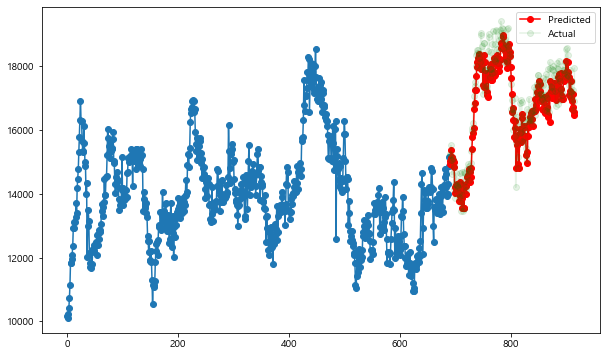

In [62]:
a_axis = np.arange(0, len(train_y))
b_axis = np.arange(len(train_y), len(train_y) + len(y_hat))

y_hat = scaler.inverse_transform(y_hat)
train_y = scaler.inverse_transform(train_y)
test_y = scaler.inverse_transform(test_y)

plt.figure(figsize=(10,6))
plt.plot(a_axis, train_y.reshape(690,), 'o-')
plt.plot(b_axis, y_hat.reshape(226,), 'o-', color='red', label='Predicted')
plt.plot(b_axis, test_y.reshape(226,), 'o-', color='green', alpha=0.1, label='Actual')
plt.legend()
plt.show()

## 예측값 다시 inverse_transform시켜서 실제값과 비교

In [63]:
y_hat_train = model.predict(train_X, batch_size=1)
y_hat_train = scaler.inverse_transform(y_hat_train)

In [64]:
print('test예측값 :',len(y_hat))
print('test실제값 :', len(test_y))

test예측값 : 226
test실제값 : 226


In [67]:
# MAPE 함수 정의하여 MAPE 값 비교
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('Train MAPE : ',mean_absolute_percentage_error(train_y,y_hat_train))
print('Test MAPE : ',mean_absolute_percentage_error(test_y,y_hat))
print()
print()

# RMSE 값 비교
import math
from sklearn.metrics import mean_squared_error

trainScore = math.sqrt(mean_squared_error(train_y,y_hat_train))
print('TrainScore, RMSE :%.d'%(trainScore))
testScore = math.sqrt(mean_squared_error(test_y,y_hat))
print('TestScore, RMSE :%.d'%(testScore))

Train MAPE :  2.510921409135971
Test MAPE :  2.5915679586593745


TrainScore, RMSE :472
TestScore, RMSE :568
